### Keras models combination

The project demonstrates application of deep learning techniques to historical data. The data used is the pantheon
dataset (http://pantheon.media.mit.edu/treemap/country_exports/EE/all/-4000/2010/H15/pantheon). 
It comprises the biographical data of 11341 persons, as well as data about their Wikipedia page views.

The project goal is to estimate the popularity of a person (Wikipedia page views) based on  the biographical 
or image data.

Four models were developed:

•Popularity classification based on biographical data;

•Popularity  classification based on biographical data with some non-scientific hypothesis (astrological);

•Popularity classification based on image data;

•Popularity classification based on merged model with two inputs: biographical and image;


The biographical and image models were developed using Keras Sequential model API, the merged model was developed
using Keras functional API. While Sequential API allows create model layer by layer, Keras Functional API allows 
create complicated models with multiple inputs, outputs, shared layers etc.
While the developed models do not reach high validation accuracy, it could be easily demonstrated that they will 
outperform usual person with common level of historical knowledge.
In the save time, it is clear that some additional domain knowledge could significantly improve model development.

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [2]:
# load libraries

get_ipython().run_line_magic('matplotlib', 'inline')

import pandas as pd
import matplotlib.pyplot as plt
import keras.utils
import numpy as np
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [3]:
# loading and exploring pantheon dataset

pantheondf=pd.read_csv('pantheon.tsv',delimiter='\t',encoding='latin-1')

In [4]:
pantheondf.head(5)

,en_curid,name,numlangs,birthcity,birthstate,countryName,countryCode,countryCode3,LAT,LON,...,occupation,industry,domain,TotalPageViews,L_star,StdDevPageViews,PageViewsEnglish,PageViewsNonEnglish,AverageViews,HPI
0,307,Abraham Lincoln,131,Hodgenville,KY,UNITED STATES,US,USA,37.571111,-85.738611,...,POLITICIAN,GOVERNMENT,INSTITUTIONS,66145211,5.801387,586914.72200,41477236,24667975,504925.2748,27.938585
1,308,Aristotle,152,Stageira,NaN,Greece,GR,GRC,40.333333,23.500000,...,PHILOSOPHER,PHILOSOPHY,HUMANITIES,56355172,11.914597,201067.46070,15745351,40609821,370757.7105,31.993795
2,339,Ayn Rand,55,Saint Petersburg,NaN,Russia,RU,RUS,59.950000,30.300000,...,WRITER,LANGUAGE,HUMANITIES,14208218,3.175685,87632.49020,11023490,3184728,258331.2364,24.325936
3,595,Andre Agassi,69,Las Vegas,NV,UNITED STATES,US,USA,36.121514,-115.173851,...,TENNIS PLAYER,INDIVIDUAL SPORTS,SPORTS,11244030,6.242525,85553.31810,6353888,4890142,162956.9565,20.925999
4,628,Aldous Huxley,62,Godalming,NaN,UNITED KINGDOM,GB,GBR,51.185000,-0.610000,...,WRITER,LANGUAGE,HUMANITIES,9268920,6.219842,33037.03209,5137256,4131664,149498.7097,25.996605


In [5]:
pantheondf.shape

(11340, 23)

In [6]:
# find quartiles

from scipy import stats

In [7]:
stats.describe(pantheondf.AverageViews)

DescribeResult(nobs=11340, minmax=(49.125, 1515231.9319999998), mean=89414.55898166022, variance=14754141143.815002, skewness=3.2023048891915185, kurtosis=15.511497226015205)

In [8]:
np.percentile(pantheondf.AverageViews, 25)

18419.595247499998

In [9]:
np.percentile(pantheondf.AverageViews, 50)

43833.757835

In [10]:
np.percentile(pantheondf.AverageViews, 75)

107232.154775

In [11]:
# assign classes depending on the Averige page views percentile

pantheondf.loc[pantheondf['AverageViews'] < 18419,'class'] = 1

In [12]:
pantheondf.loc[pantheondf['AverageViews'] > 107228,'class'] = 4

In [13]:
pantheondf.loc[(pantheondf['AverageViews'] > 18419) 
               & (pantheondf['AverageViews'] < 43843),'class'] = 2

In [14]:
pantheondf.loc[(pantheondf['AverageViews'] > 43843) 
               & (pantheondf['AverageViews'] < 107228),'class'] = 3

In [15]:
pantheondf.head(10)

,en_curid,name,numlangs,birthcity,birthstate,countryName,countryCode,countryCode3,LAT,LON,...,industry,domain,TotalPageViews,L_star,StdDevPageViews,PageViewsEnglish,PageViewsNonEnglish,AverageViews,HPI,class
0,307,Abraham Lincoln,131,Hodgenville,KY,UNITED STATES,US,USA,37.571111,-85.738611,...,GOVERNMENT,INSTITUTIONS,66145211,5.801387,586914.72200,41477236,24667975,504925.2748,27.938585,4.0
1,308,Aristotle,152,Stageira,NaN,Greece,GR,GRC,40.333333,23.500000,...,PHILOSOPHY,HUMANITIES,56355172,11.914597,201067.46070,15745351,40609821,370757.7105,31.993795,4.0
2,339,Ayn Rand,55,Saint Petersburg,NaN,Russia,RU,RUS,59.950000,30.300000,...,LANGUAGE,HUMANITIES,14208218,3.175685,87632.49020,11023490,3184728,258331.2364,24.325936,4.0
3,595,Andre Agassi,69,Las Vegas,NV,UNITED STATES,US,USA,36.121514,-115.173851,...,INDIVIDUAL SPORTS,SPORTS,11244030,6.242525,85553.31810,6353888,4890142,162956.9565,20.925999,4.0
4,628,Aldous Huxley,62,Godalming,NaN,UNITED KINGDOM,GB,GBR,51.185000,-0.610000,...,LANGUAGE,HUMANITIES,9268920,6.219842,33037.03209,5137256,4131664,149498.7097,25.996605,4.0
5,700,Arthur Schopenhauer,79,Gdaãsk,NaN,POLAND,PL,POL,54.350000,18.633333,...,PHILOSOPHY,HUMANITIES,11622780,12.666215,61718.81469,2743101,8879679,147123.7975,27.776020,4.0
6,736,Albert Einstein,166,Ulm,NaN,Germany,DE,DEU,48.400000,9.983333,...,NATURAL SCIENCES,SCIENCE & TECHNOLOGY,89771090,11.501201,342755.95500,34276454,55494636,540789.6988,30.210614,4.0
7,783,Alexander the Great,138,Pella,NaN,Greece,GR,GRC,40.800000,22.516667,...,MILITARY,INSTITUTIONS,48358148,11.182406,153675.91720,19942587,28415561,350421.3623,31.583952,4.0
8,808,Alfred Hitchcock,100,Leytonstone,NaN,UNITED KINGDOM,GB,GBR,51.569000,0.010000,...,FILM AND THEATRE,ARTS,23216701,8.349061,164426.30510,10496279,12720422,232167.0100,27.175982,4.0
9,841,Attila the Hun,83,HajdÌ¼bÌ¦szÌ¦rmÌ©ny,NaN,Hungary,HU,HUN,NaN,NaN,...,GOVERNMENT,INSTITUTIONS,11123103,13.975813,59842.86906,2971786,8151317,134013.2892,29.243327,4.0


In [16]:
# check data distribution

set(pantheondf["class"])

{1.0, 2.0, 3.0, 4.0}

In [17]:
import collections

In [18]:
counter=collections.Counter(pantheondf['class'])

In [19]:
print(counter)

Counter({4.0: 2836, 2.0: 2836, 3.0: 2834, 1.0: 2834})


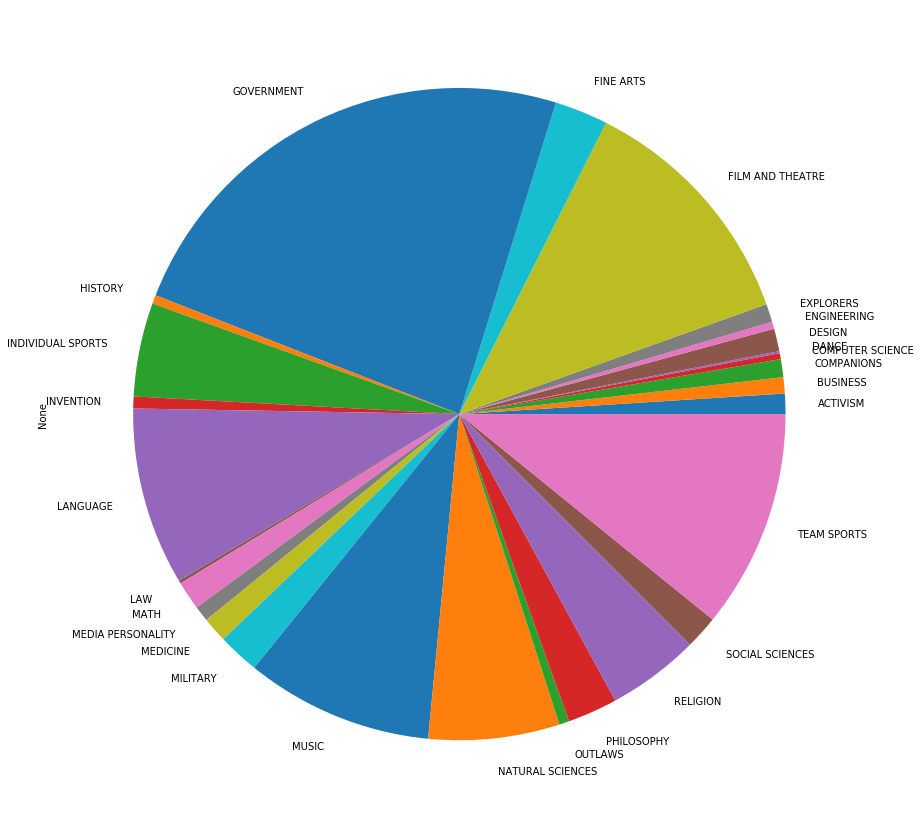

In [20]:
pantheondf.groupby(['industry']).size().plot.pie(figsize=(15, 15))

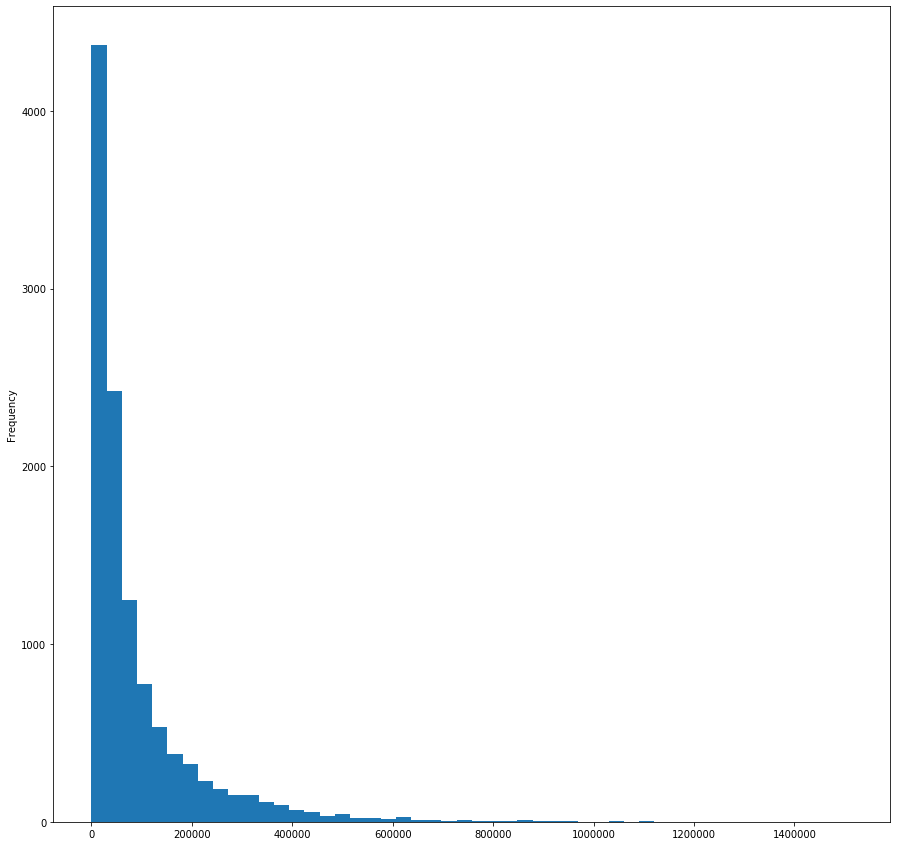

In [21]:
pantheondf['AverageViews'].plot.hist(bins=50, figsize=(15, 15))

In [22]:
pantheondf.columns

Index(['en_curid', 'name', 'numlangs', 'birthcity', 'birthstate',
       'countryName', 'countryCode', 'countryCode3', 'LAT', 'LON',
       'continentName', 'birthyear', 'gender', 'occupation', 'industry',
       'domain', 'TotalPageViews', 'L_star', 'StdDevPageViews',
       'PageViewsEnglish', 'PageViewsNonEnglish', 'AverageViews', 'HPI',
       'class'],
      dtype='object')

In [23]:
pantheondf = pantheondf[['LAT', 'LON', 'birthyear', 'gender',
                         'occupation', 'industry', 'domain', 'class']]

In [24]:
pantheondf.head(10)

,LAT,LON,birthyear,gender,occupation,industry,domain,class
0,37.571111,-85.738611,1809,Male,POLITICIAN,GOVERNMENT,INSTITUTIONS,4.0
1,40.333333,23.500000,-384,Male,PHILOSOPHER,PHILOSOPHY,HUMANITIES,4.0
2,59.950000,30.300000,1905,Female,WRITER,LANGUAGE,HUMANITIES,4.0
3,36.121514,-115.173851,1970,Male,TENNIS PLAYER,INDIVIDUAL SPORTS,SPORTS,4.0
4,51.185000,-0.610000,1894,Male,WRITER,LANGUAGE,HUMANITIES,4.0
5,54.350000,18.633333,1788,Male,PHILOSOPHER,PHILOSOPHY,HUMANITIES,4.0
6,48.400000,9.983333,1879,Male,PHYSICIST,NATURAL SCIENCES,SCIENCE & TECHNOLOGY,4.0
7,40.800000,22.516667,-356,Male,MILITARY PERSONNEL,MILITARY,INSTITUTIONS,4.0
8,51.569000,0.010000,1899,Male,FILM DIRECTOR,FILM AND THEATRE,ARTS,4.0
9,NaN,NaN,406,Male,POLITICIAN,GOVERNMENT,INSTITUTIONS,4.0


In [25]:
pantheondf.fillna(0)

,LAT,LON,birthyear,gender,occupation,industry,domain,class
0,37.571111,-85.738611,1809,Male,POLITICIAN,GOVERNMENT,INSTITUTIONS,4.0
1,40.333333,23.500000,-384,Male,PHILOSOPHER,PHILOSOPHY,HUMANITIES,4.0
2,59.950000,30.300000,1905,Female,WRITER,LANGUAGE,HUMANITIES,4.0
3,36.121514,-115.173851,1970,Male,TENNIS PLAYER,INDIVIDUAL SPORTS,SPORTS,4.0
4,51.185000,-0.610000,1894,Male,WRITER,LANGUAGE,HUMANITIES,4.0
...,...,...,...,...,...,...,...,...
11335,0.000000,0.000000,-3500,Female,RELIGIOUS FIGURE,RELIGION,INSTITUTIONS,3.0
11336,55.000000,24.000000,1200,Male,POLITICIAN,GOVERNMENT,INSTITUTIONS,2.0
11337,0.000000,0.000000,1275,Male,POLITICIAN,GOVERNMENT,INSTITUTIONS,2.0
11338,31.200000,29.916667,1917,Male,HISTORIAN,HISTORY,HUMANITIES,3.0


In [26]:
pantheondf.dtypes

LAT           float64
LON           float64
birthyear      object
gender         object
occupation     object
industry       object
domain         object
class         float64
dtype: object

In [27]:
print(pantheondf.describe())

                LAT           LON         class
count  10294.000000  10294.000000  11340.000000
mean      39.931860     -7.039516      2.500176
std       18.688257     55.118931      1.118083
min      -51.633333   -175.200556      1.000000
25%       37.916667    -56.072708      2.000000
50%       43.716667      4.483333      2.500000
75%       50.936389     17.210000      4.000000
max       70.073333    178.017778      4.000000


In [28]:
pantheondf['birthyear'] = pantheondf['birthyear'].str.extract('(\d+)', expand=False)

In [29]:
pantheondf['birthyear'] = pantheondf['birthyear'].apply(pd.to_numeric, errors='coerce').fillna(0, downcast='infer')

In [30]:
print(pantheondf.describe())

                LAT           LON     birthyear         class
count  10294.000000  10294.000000  11340.000000  11340.000000
mean      39.931860     -7.039516   1733.215873      2.500176
std       18.688257     55.118931    471.067206      1.118083
min      -51.633333   -175.200556      0.000000      1.000000
25%       37.916667    -56.072708   1801.000000      2.000000
50%       43.716667      4.483333   1920.000000      2.500000
75%       50.936389     17.210000   1962.000000      4.000000
max       70.073333    178.017778   3500.000000      4.000000


In [31]:
pantheondf.loc[pantheondf['birthyear'] > 2018,'birthyear'] = 0

In [32]:
print(pantheondf.describe())

                LAT           LON     birthyear         class
count  10294.000000  10294.000000  11340.000000  11340.000000
mean      39.931860     -7.039516   1715.393739      2.500176
std       18.688257     55.118931    478.557745      1.118083
min      -51.633333   -175.200556      0.000000      1.000000
25%       37.916667    -56.072708   1792.000000      2.000000
50%       43.716667      4.483333   1919.000000      2.500000
75%       50.936389     17.210000   1961.000000      4.000000
max       70.073333    178.017778   2005.000000      4.000000


In [33]:
pantheondf['LAT'] = pantheondf['LAT'].apply(pd.to_numeric, errors='coerce').fillna(0, downcast='infer')

In [34]:
print(pantheondf.describe())

                LAT           LON     birthyear         class
count  11340.000000  10294.000000  11340.000000  11340.000000
mean      36.248551     -7.039516   1715.393739      2.500176
std       21.226390     55.118931    478.557745      1.118083
min      -51.633333   -175.200556      0.000000      1.000000
25%       34.021944    -56.072708   1792.000000      2.000000
50%       42.325694      4.483333   1919.000000      2.500000
75%       50.266667     17.210000   1961.000000      4.000000
max       70.073333    178.017778   2005.000000      4.000000


In [35]:
pantheondf['LON'] = pantheondf['LON'].apply(pd.to_numeric, errors='coerce').fillna(0, downcast='infer')

In [36]:
print(pantheondf.describe())

                LAT           LON     birthyear         class
count  11340.000000  11340.000000  11340.000000  11340.000000
mean      36.248551     -6.390192   1715.393739      2.500176
std       21.226390     52.554618    478.557745      1.118083
min      -51.633333   -175.200556      0.000000      1.000000
25%       34.021944     -8.621953   1792.000000      2.000000
50%       42.325694      2.250000   1919.000000      2.500000
75%       50.266667     15.327708   1961.000000      4.000000
max       70.073333    178.017778   2005.000000      4.000000


In [37]:
# one hot encoding

def to_one_hot(data):
    
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(data)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

In [38]:
pantheondf.columns

Index(['LAT', 'LON', 'birthyear', 'gender', 'occupation', 'industry', 'domain',
       'class'],
      dtype='object')

In [39]:
matrix_LAT = np.asmatrix(pantheondf['LAT']).T

In [40]:
matrix_LON = np.asmatrix(pantheondf['LON']).T

In [41]:
matrix_birthyear = np.asmatrix(pantheondf['birthyear']).T

In [42]:
matrix_birthyear.shape

(11340, 1)

In [43]:
oh_gender = to_one_hot(pantheondf['gender'])

In [44]:
oh_occupation = to_one_hot(pantheondf['occupation'])

In [45]:
oh_industry = to_one_hot(pantheondf['industry'])

In [46]:
oh_domain = to_one_hot(pantheondf['domain'])

In [47]:
targets = to_one_hot(pantheondf['class'])

In [48]:
data_raw = pd.DataFrame(np.concatenate((matrix_LAT, matrix_LAT,
                                        matrix_birthyear, oh_gender,
                                        oh_occupation,
                        oh_industry, oh_domain), axis=1 ))

In [49]:
data_raw.shape

(11340, 128)

In [50]:
targets.shape

(11340, 4)

In [51]:
# data scaling

from sklearn import preprocessing

In [52]:
data_scaled = preprocessing.scale(data_raw)

In [53]:
data_scaled

array([[ 0.0623101 ,  0.0623101 ,  0.19560939, ..., -0.18055137,
        -0.37007578, -0.42804443],
       [ 0.19244734,  0.19244734, -2.78221899, ..., -0.18055137,
        -0.37007578, -0.42804443],
       [ 1.11665215,  1.11665215,  0.39622099, ..., -0.18055137,
        -0.37007578, -0.42804443],
       ...,
       [-1.7077868 , -1.7077868 , -0.92029261, ..., -0.18055137,
        -0.37007578, -0.42804443],
       [-0.2378536 , -0.2378536 ,  0.42129744, ..., -0.18055137,
        -0.37007578, -0.42804443],
       [ 0.72011567,  0.72011567,  0.23531377, ..., -0.18055137,
        -0.37007578, -0.42804443]])

In [54]:
train_range = int(round((data_scaled.shape[0]*0.8),0))

In [55]:
train_data = data_scaled[:train_range, :]

In [56]:
train_targets = targets[:train_range, :]

In [57]:
test_data = data_scaled[train_range:, :]

In [58]:
test_targets = targets[train_range:, :]

###  Classification based on numerical data

In [59]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

In [60]:
train_data.shape

(9072, 128)

In [61]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(128,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [62]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.categorical_crossentropy,
              metrics=[metrics.categorical_accuracy])

In [63]:
history = model.fit(train_data,
                    train_targets,
                    epochs=20,
                    batch_size=512,
                    validation_data=(test_data, test_targets))

Train on 9072 samples, validate on 2268 samples
Epoch 1/20
9072/9072 [==============================] - 0s 28us/step - loss: 1.3845 - categorical_accuracy: 0.3534 - val_loss: 1.3342 - val_categorical_accuracy: 0.3832
Epoch 2/20
9072/9072 [==============================] - 0s 9us/step - loss: 1.3091 - categorical_accuracy: 0.4276 - val_loss: 1.2840 - val_categorical_accuracy: 0.4422
Epoch 3/20
9072/9072 [==============================] - 0s 8us/step - loss: 1.2521 - categorical_accuracy: 0.4605 - val_loss: 1.2477 - val_categorical_accuracy: 0.4625
Epoch 4/20
9072/9072 [==============================] - 0s 6us/step - loss: 1.2104 - categorical_accuracy: 0.4721 - val_loss: 1.2254 - val_categorical_accuracy: 0.4696
Epoch 5/20
9072/9072 [==============================] - 0s 6us/step - loss: 1.1812 - categorical_accuracy: 0.4819 - val_loss: 1.2116 - val_categorical_accuracy: 0.4740
Epoch 6/20
9072/9072 [==============================] - 0s 10us/step - loss: 1.1592 - categorical_accuracy: 0.4

In [64]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])

In [65]:
import matplotlib.pyplot as plt

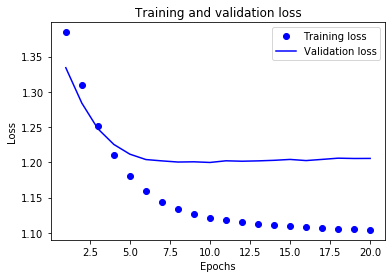

In [66]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

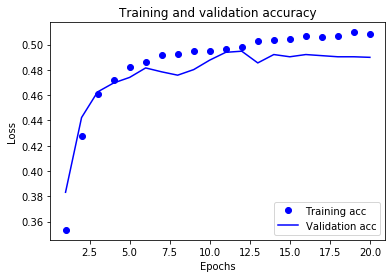

In [67]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### smaller model

In [68]:
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(128,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(4, activation='softmax'))

In [69]:
smaller_model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.categorical_crossentropy,
              metrics=[metrics.categorical_accuracy])

In [70]:
smaller_model_hist = smaller_model.fit(train_data,
                    train_targets,
                    epochs=20,
                    batch_size=512,
                    validation_data=(test_data, test_targets))

Train on 9072 samples, validate on 2268 samples
Epoch 1/20
9072/9072 [==============================] - 0s 16us/step - loss: 1.3996 - categorical_accuracy: 0.3233 - val_loss: 1.3745 - val_categorical_accuracy: 0.3695
Epoch 2/20
9072/9072 [==============================] - 0s 6us/step - loss: 1.3827 - categorical_accuracy: 0.3795 - val_loss: 1.3623 - val_categorical_accuracy: 0.4083
Epoch 3/20
9072/9072 [==============================] - 0s 5us/step - loss: 1.3707 - categorical_accuracy: 0.3770 - val_loss: 1.3509 - val_categorical_accuracy: 0.3920
Epoch 4/20
9072/9072 [==============================] - 0s 5us/step - loss: 1.3592 - categorical_accuracy: 0.3790 - val_loss: 1.3375 - val_categorical_accuracy: 0.4008
Epoch 5/20
9072/9072 [==============================] - 0s 5us/step - loss: 1.3471 - categorical_accuracy: 0.3819 - val_loss: 1.3239 - val_categorical_accuracy: 0.4021
Epoch 6/20
9072/9072 [==============================] - 0s 5us/step - loss: 1.3342 - categorical_accuracy: 0.38

In [71]:
epochs = range(1, 21)
original_val_loss = history.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

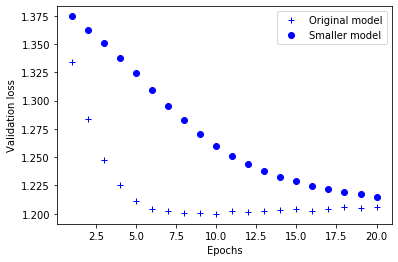

In [72]:
# b+ is for "blue cross"
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
# "bo" is for "blue dot"
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

#### bigger model

In [73]:
bigger_model = models.Sequential()
bigger_model.add(layers.Dense(512, activation='relu', input_shape=(128,)))
bigger_model.add(layers.Dense(512, activation='relu'))
bigger_model.add(layers.Dense(4, activation='softmax'))

In [74]:
bigger_model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.categorical_crossentropy,
              metrics=[metrics.categorical_accuracy])

In [75]:
bigger_model_hist = bigger_model.fit(train_data,
                    train_targets,
                    epochs=20,
                    batch_size=512,
                    validation_data=(test_data, test_targets))

Train on 9072 samples, validate on 2268 samples
Epoch 1/20
9072/9072 [==============================] - 0s 37us/step - loss: 1.2915 - categorical_accuracy: 0.4472 - val_loss: 1.1929 - val_categorical_accuracy: 0.4947
Epoch 2/20
9072/9072 [==============================] - 0s 29us/step - loss: 1.1427 - categorical_accuracy: 0.4932 - val_loss: 1.2629 - val_categorical_accuracy: 0.4683
Epoch 3/20
9072/9072 [==============================] - 0s 28us/step - loss: 1.1375 - categorical_accuracy: 0.4889 - val_loss: 1.2275 - val_categorical_accuracy: 0.4832
Epoch 4/20
9072/9072 [==============================] - 0s 29us/step - loss: 1.1234 - categorical_accuracy: 0.4972 - val_loss: 1.2241 - val_categorical_accuracy: 0.4788
Epoch 5/20
9072/9072 [==============================] - 0s 30us/step - loss: 1.1154 - categorical_accuracy: 0.5021 - val_loss: 1.2314 - val_categorical_accuracy: 0.4740
Epoch 6/20
9072/9072 [==============================] - 0s 30us/step - loss: 1.1147 - categorical_accuracy:

In [76]:
bigger_model_val_loss = bigger_model_hist.history['val_loss']

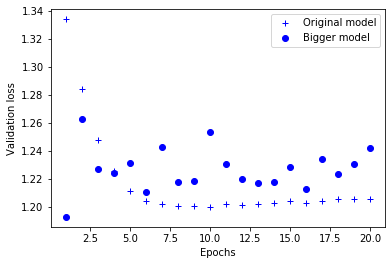

In [77]:
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_val_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

 #### regularized model

In [78]:
from keras import regularizers

In [79]:
l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(128,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(4, activation='softmax'))

In [80]:
l2_model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.categorical_crossentropy,
              metrics=[metrics.categorical_accuracy])

In [81]:
l2_model_hist = l2_model.fit(train_data,
                    train_targets,
                    epochs=20,
                    batch_size=512,
                    validation_data=(test_data, test_targets))

Train on 9072 samples, validate on 2268 samples
Epoch 1/20
9072/9072 [==============================] - 0s 17us/step - loss: 1.4930 - categorical_accuracy: 0.3348 - val_loss: 1.3908 - val_categorical_accuracy: 0.4162
Epoch 2/20
9072/9072 [==============================] - 0s 6us/step - loss: 1.3680 - categorical_accuracy: 0.4162 - val_loss: 1.3323 - val_categorical_accuracy: 0.4453
Epoch 3/20
9072/9072 [==============================] - 0s 6us/step - loss: 1.3048 - categorical_accuracy: 0.4513 - val_loss: 1.2899 - val_categorical_accuracy: 0.4524
Epoch 4/20
9072/9072 [==============================] - 0s 6us/step - loss: 1.2563 - categorical_accuracy: 0.4715 - val_loss: 1.2608 - val_categorical_accuracy: 0.4616
Epoch 5/20
9072/9072 [==============================] - 0s 7us/step - loss: 1.2225 - categorical_accuracy: 0.4791 - val_loss: 1.2460 - val_categorical_accuracy: 0.4643
Epoch 6/20
9072/9072 [==============================] - 0s 8us/step - loss: 1.1996 - categorical_accuracy: 0.48

In [82]:
l2_model_val_loss = l2_model_hist.history['val_loss']

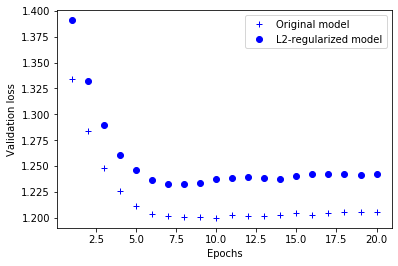

In [83]:
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

#### model with dropout

In [84]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(128,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(4, activation='softmax'))

In [85]:
dpt_model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.categorical_crossentropy,
              metrics=[metrics.categorical_accuracy])

In [86]:
dpt_model_hist = dpt_model.fit(train_data,
                    train_targets,
                    epochs=20,
                    batch_size=512,
                    validation_data=(test_data, test_targets))

Train on 9072 samples, validate on 2268 samples
Epoch 1/20
9072/9072 [==============================] - 0s 24us/step - loss: 1.7783 - categorical_accuracy: 0.2834 - val_loss: 1.4172 - val_categorical_accuracy: 0.3108
Epoch 2/20
9072/9072 [==============================] - 0s 6us/step - loss: 1.6424 - categorical_accuracy: 0.2814 - val_loss: 1.3792 - val_categorical_accuracy: 0.3417
Epoch 3/20
9072/9072 [==============================] - 0s 6us/step - loss: 1.5394 - categorical_accuracy: 0.3026 - val_loss: 1.3586 - val_categorical_accuracy: 0.3360
Epoch 4/20
9072/9072 [==============================] - 0s 7us/step - loss: 1.4764 - categorical_accuracy: 0.3157 - val_loss: 1.3433 - val_categorical_accuracy: 0.3739
Epoch 5/20
9072/9072 [==============================] - 0s 7us/step - loss: 1.4474 - categorical_accuracy: 0.3223 - val_loss: 1.3304 - val_categorical_accuracy: 0.3889
Epoch 6/20
9072/9072 [==============================] - 0s 7us/step - loss: 1.4033 - categorical_accuracy: 0.33

In [87]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

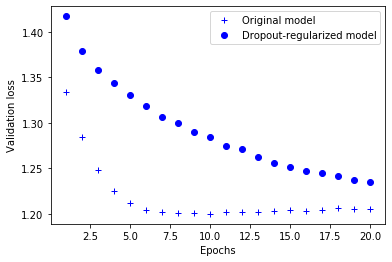

In [88]:
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

 ### Classification based on numerical data with  astrological view

In [89]:
oh_birthyear = to_one_hot(round(pantheondf['birthyear'] % 12,0))

In [90]:
oh_birthyear.shape

(11340, 12)

In [91]:
data_rawA = pd.DataFrame(np.concatenate((matrix_LAT, matrix_LAT,
                                         oh_birthyear, oh_gender, oh_occupation,
                        oh_industry, oh_domain), axis=1 ))

In [92]:
data_scaledA = preprocessing.scale(data_rawA)

In [93]:
train_dataA = data_scaledA[:train_range, :]

In [94]:
test_dataA = data_scaledA[train_range:, :]

In [95]:
train_dataA.shape

(9072, 139)

In [96]:
modelA = models.Sequential()
modelA.add(layers.Dense(16, activation='relu', input_shape=(139,)))
modelA.add(layers.Dense(16, activation='relu'))
modelA.add(layers.Dense(4, activation='softmax'))

In [97]:
modelA.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.categorical_crossentropy,
              metrics=[metrics.categorical_accuracy])

In [98]:
historyA = modelA.fit(train_dataA,
                    train_targets,
                    epochs=20,
                    batch_size=512,
                    validation_data=(test_dataA, test_targets))

Train on 9072 samples, validate on 2268 samples
Epoch 1/20
9072/9072 [==============================] - 0s 29us/step - loss: 1.4716 - categorical_accuracy: 0.3309 - val_loss: 1.3962 - val_categorical_accuracy: 0.3682
Epoch 2/20
9072/9072 [==============================] - 0s 10us/step - loss: 1.3318 - categorical_accuracy: 0.4148 - val_loss: 1.3121 - val_categorical_accuracy: 0.4361
Epoch 3/20
9072/9072 [==============================] - 0s 11us/step - loss: 1.2605 - categorical_accuracy: 0.4480 - val_loss: 1.2654 - val_categorical_accuracy: 0.4497
Epoch 4/20
9072/9072 [==============================] - 0s 11us/step - loss: 1.2110 - categorical_accuracy: 0.4672 - val_loss: 1.2409 - val_categorical_accuracy: 0.4731
Epoch 5/20
9072/9072 [==============================] - 0s 10us/step - loss: 1.1797 - categorical_accuracy: 0.4787 - val_loss: 1.2284 - val_categorical_accuracy: 0.4815
Epoch 6/20
9072/9072 [==============================] - 0s 9us/step - loss: 1.1610 - categorical_accuracy: 

In [99]:
astro_model_val_loss = historyA.history['val_loss']

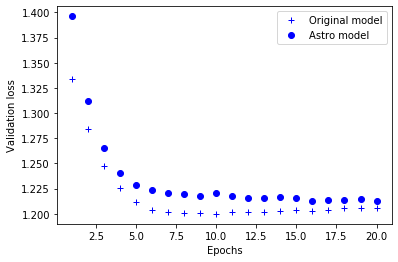

In [100]:
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, astro_model_val_loss, 'bo', label='Astro model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

In [101]:
original_val_acc = history.history['val_categorical_accuracy']

In [102]:
astro_val_acc = historyA.history['val_categorical_accuracy']

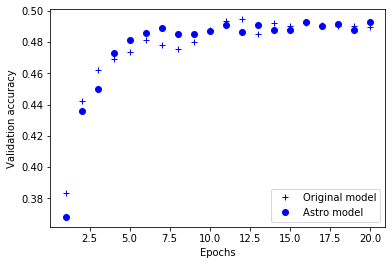

In [103]:
plt.plot(epochs, original_val_acc, 'b+', label='Original model')
plt.plot(epochs, astro_val_acc, 'bo', label='Astro model')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.legend()

plt.show()

In [104]:
from keras.models import load_model

In [105]:
model.save('numerical_model.h5')

In [106]:
modelA.save('astro_model.h5')

In [107]:
np.savetxt('train_data.csv', train_data, delimiter=',')

In [108]:
np.savetxt('test_data.csv', test_data, delimiter=',')

In [109]:
np.savetxt('train_targets.csv', train_targets, delimiter=',')

In [110]:
np.savetxt('test_targets.csv', test_targets, delimiter=',')

In [111]:
np.savetxt('train_dataA.csv', train_dataA, delimiter=',')

In [112]:
np.savetxt('test_dataA.csv', test_dataA, delimiter=',')

In [113]:
counterA = collections.Counter(round(pantheondf['birthyear'] % 12,0))

In [114]:
print(counterA)

Counter({8: 1073, 4: 1034, 0: 1028, 10: 973, 6: 947, 5: 924, 2: 922, 9: 909, 1: 897, 11: 892, 3: 887, 7: 854})


In [115]:
pantheondf['astro'] = round(pantheondf['birthyear'] % 12,0)

In [116]:
pantheondf.head(5)

,LAT,LON,birthyear,gender,occupation,industry,domain,class,astro
0,37.571111,-85.738611,1809,Male,POLITICIAN,GOVERNMENT,INSTITUTIONS,4.0,9
1,40.333333,23.500000,384,Male,PHILOSOPHER,PHILOSOPHY,HUMANITIES,4.0,0
2,59.950000,30.300000,1905,Female,WRITER,LANGUAGE,HUMANITIES,4.0,9
3,36.121514,-115.173851,1970,Male,TENNIS PLAYER,INDIVIDUAL SPORTS,SPORTS,4.0,2
4,51.185000,-0.610000,1894,Male,WRITER,LANGUAGE,HUMANITIES,4.0,10


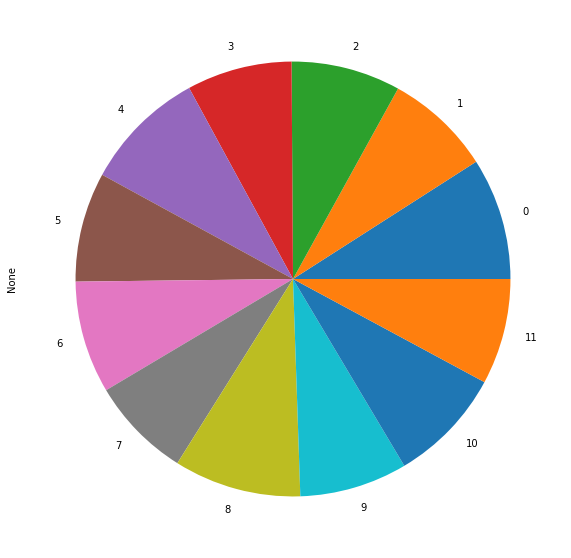

In [117]:
pantheondf.groupby(['astro']).size().plot.pie(figsize=(10, 10))

### preparing image data

In [118]:
import os, shutil

In [119]:
original_dataset_dir = './img'

In [120]:
base_dir = './img/processed'

In [121]:
train_dir = './img/processed/train'

In [122]:
test_dir = './img/processed/test'

In [123]:
train_1_dir = './img/processed/train/1'

In [124]:
train_2_dir = './img/processed/train/2'

In [125]:
train_3_dir = './img/processed/train/3'

In [126]:
train_4_dir = './img/processed/train/4'

In [127]:
test_1_dir = './img/processed/test/1'

In [128]:
test_2_dir = './img/processed/test/2'

In [129]:
test_3_dir = './img/processed/test/3'

In [130]:
test_4_dir = './img/processed/test/4'

In [131]:
print('total test 4 images:', len(os.listdir(test_4_dir)))

total test 4 images: 11


In [132]:
from keras.preprocessing.image import ImageDataGenerator

In [133]:
# all images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [134]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use categorical
        class_mode='categorical')

Found 181 images belonging to 4 classes.


In [135]:
validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 20 images belonging to 4 classes.


### Image classification

In [136]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [137]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [138]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss=losses.categorical_crossentropy,
              metrics=[metrics.categorical_accuracy])

In [139]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
        #30
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 194s 2s/step - loss: 1.3117 - categorical_accuracy: 0.3895 - val_loss: 1.6402 - val_categorical_accuracy: 0.0000e+00
Epoch 2/30
100/100 [==============================] - 161s 2s/step - loss: 1.0081 - categorical_accuracy: 0.6044 - val_loss: 1.2899 - val_categorical_accuracy: 0.4500
Epoch 3/30
100/100 [==============================] - 163s 2s/step - loss: 0.6541 - categorical_accuracy: 0.7873 - val_loss: 1.1956 - val_categorical_accuracy: 0.4000
Epoch 4/30
100/100 [==============================] - 164s 2s/step - loss: 0.3442 - categorical_accuracy: 0.9193 - val_loss: 2.3795 - val_categorical_accuracy: 0.3000
Epoch 5/30
100/100 [==============================] - 176s 2s/step - loss: 0.1433 - categorical_accuracy: 0.9680 - val_loss: 1.7261 - val_categorical_accuracy: 0.5000
Epoch 6/30
100/100 [==============================] - 169s 2s/step - loss: 0.0482 - categorical_accuracy: 0.9928 - val_loss: 1.9368 - val_categorical_accuracy: 0

In [140]:
model.save('img_model.h5')

In [141]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

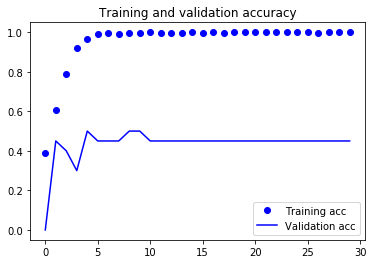

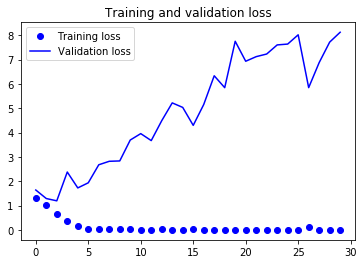

In [142]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [143]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

#### augmentation and dropout

In [144]:
# this is module with image preprocessing utilities
from keras.preprocessing import image

In [145]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [146]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss=losses.categorical_crossentropy,
              metrics=[metrics.categorical_accuracy])

In [147]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

In [148]:
# note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [149]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use categorical
        class_mode='categorical')

Found 181 images belonging to 4 classes.


In [150]:
validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

Found 20 images belonging to 4 classes.


In [151]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      #100
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 297s 3s/step - loss: 1.3811 - categorical_accuracy: 0.2831 - val_loss: 1.3728 - val_categorical_accuracy: 0.4000
Epoch 2/100
100/100 [==============================] - 285s 3s/step - loss: 1.3488 - categorical_accuracy: 0.3354 - val_loss: 1.6261 - val_categorical_accuracy: 0.2000
Epoch 3/100
100/100 [==============================] - 260s 3s/step - loss: 1.3148 - categorical_accuracy: 0.3664 - val_loss: 1.3472 - val_categorical_accuracy: 0.4500
Epoch 4/100
100/100 [==============================] - 243s 2s/step - loss: 1.2876 - categorical_accuracy: 0.3767 - val_loss: 1.5112 - val_categorical_accuracy: 0.3000
Epoch 5/100
100/100 [==============================] - 250s 2s/step - loss: 1.2590 - categorical_accuracy: 0.4038 - val_loss: 1.3265 - val_categorical_accuracy: 0.5000
Epoch 6/100
100/100 [==============================] - 249s 2s/step - loss: 1.2434 - categorical_accuracy: 0.4189 - val_loss: 1.9587 - val_categorical_accuracy:

100/100 [==============================] - 275s 3s/step - loss: 0.3431 - categorical_accuracy: 0.8714 - val_loss: 5.1605 - val_categorical_accuracy: 0.2000
Epoch 50/100
100/100 [==============================] - 250s 2s/step - loss: 0.3181 - categorical_accuracy: 0.8771 - val_loss: 4.8761 - val_categorical_accuracy: 0.1500
Epoch 51/100
100/100 [==============================] - 251s 3s/step - loss: 0.3276 - categorical_accuracy: 0.8859 - val_loss: 4.7157 - val_categorical_accuracy: 0.2000
Epoch 52/100
100/100 [==============================] - 244s 2s/step - loss: 0.3029 - categorical_accuracy: 0.8905 - val_loss: 5.2636 - val_categorical_accuracy: 0.1000
Epoch 53/100
100/100 [==============================] - 246s 2s/step - loss: 0.2848 - categorical_accuracy: 0.8928 - val_loss: 6.3241 - val_categorical_accuracy: 0.1000
Epoch 54/100
100/100 [==============================] - 251s 3s/step - loss: 0.2969 - categorical_accuracy: 0.8866 - val_loss: 5.2786 - val_categorical_accuracy: 0.2500

100/100 [==============================] - 240s 2s/step - loss: 0.1108 - categorical_accuracy: 0.9638 - val_loss: 8.4881 - val_categorical_accuracy: 0.2000
Epoch 98/100
100/100 [==============================] - 244s 2s/step - loss: 0.1246 - categorical_accuracy: 0.9560 - val_loss: 8.1581 - val_categorical_accuracy: 0.1500
Epoch 99/100
100/100 [==============================] - 242s 2s/step - loss: 0.1035 - categorical_accuracy: 0.9642 - val_loss: 9.5985 - val_categorical_accuracy: 0.0500
Epoch 100/100
100/100 [==============================] - 240s 2s/step - loss: 0.1226 - categorical_accuracy: 0.9575 - val_loss: 7.9746 - val_categorical_accuracy: 0.1500


In [152]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

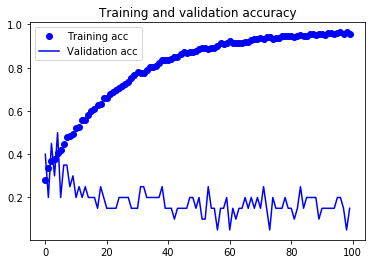

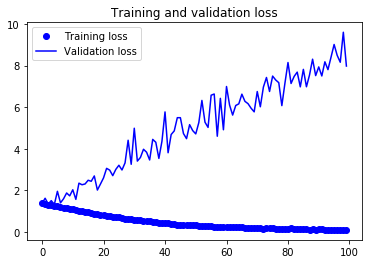

In [153]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [154]:
model.save('imgAug_model.h5')

### Merge models

In [155]:
from keras.models import load_model

In [156]:
astro_model = load_model('astro_model.h5')

In [157]:
img_model = load_model('img_model.h5')

In [158]:
train_dataA.shape

(9072, 139)

In [159]:
small_dataA = train_dataA[:201, :]

In [160]:
small_dataA.shape

(201, 139)

In [161]:
targets.shape

(11340, 4)

In [162]:
small_targets = targets[:201, :]

In [163]:
small_targets.shape

(201, 4)

In [164]:
train_small_dataA = small_dataA[:181, :]

In [165]:
train_small_dataA.shape

(181, 139)

In [166]:
test_small_dataA = small_dataA[181:,:]

In [167]:
test_small_dataA.shape

(20, 139)

In [168]:
train_small_targets = small_targets[:181,:]

In [169]:
train_small_targets.shape

(181, 4)

In [170]:
test_small_targets = small_targets[181:,:]

In [171]:
test_small_targets.shape

(20, 4)

In [173]:
type (test_small_dataA)

numpy.ndarray

In [174]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model

#### merged model

In [175]:
num_input = Input(shape=(139,))

In [176]:
num_output = astro_model(num_input)

In [177]:
img_input = Input(shape=(150, 150, 3))

In [178]:
img_output = img_model(img_input)

In [179]:
x = keras.layers.concatenate([num_output, img_output])

In [180]:
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

In [181]:
main_output = Dense(4, activation='softmax', name='main_output')(x)

In [182]:
model = Model(inputs=[num_input, img_input], outputs=[main_output])

In [183]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

### prepare image data

In [184]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [185]:
itr = train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=181,
        # Since we use categorical
        class_mode='categorical')

Found 181 images belonging to 4 classes.


In [186]:
img_array, img_targets = itr.next()

In [187]:
img_array.shape

(181, 150, 150, 3)

In [188]:
img_targets.shape

(181, 4)

In [189]:
history = model.fit([train_small_dataA, img_array], [train_small_targets],
          epochs=30, validation_split=0.2, batch_size=20)

Train on 144 samples, validate on 37 samples
Epoch 1/30
144/144 [==============================] - 4s 30ms/step - loss: 1.3911 - categorical_accuracy: 0.2431 - val_loss: 1.3726 - val_categorical_accuracy: 0.3784
Epoch 2/30
144/144 [==============================] - 4s 28ms/step - loss: 1.3709 - categorical_accuracy: 0.3194 - val_loss: 1.3597 - val_categorical_accuracy: 0.3784
Epoch 3/30
144/144 [==============================] - 5s 32ms/step - loss: 1.3560 - categorical_accuracy: 0.3750 - val_loss: 1.3500 - val_categorical_accuracy: 0.4324
Epoch 4/30
144/144 [==============================] - 4s 26ms/step - loss: 1.3383 - categorical_accuracy: 0.3819 - val_loss: 1.3312 - val_categorical_accuracy: 0.4324
Epoch 5/30
144/144 [==============================] - 4s 25ms/step - loss: 1.3204 - categorical_accuracy: 0.3958 - val_loss: 1.3174 - val_categorical_accuracy: 0.4324
Epoch 6/30
144/144 [==============================] - 4s 25ms/step - loss: 1.2985 - categorical_accuracy: 0.4167 - val_l

In [190]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

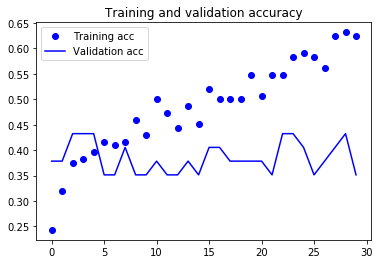

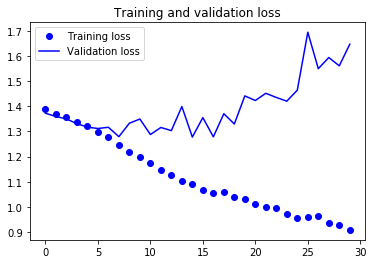

In [191]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()